In [17]:
import torch
import gc
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random

%load_ext autoreload
%autoreload 2

from EVO import LogisticRegression, DeepNeuralNetwork, EvolutionOptimizer, GradientDescentOptimizer

device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps"  if torch.backends.mps.is_available()
    else "cpu"
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
def classification_data(n_points=1000, p_dims=2, noise=0.2, add_bias=True):
    torch.manual_seed(0)
    X = torch.randn(n_points, p_dims)
    true_w = torch.randn(p_dims + 1)
    if add_bias:
        X_with_bias = torch.cat([X, torch.ones(n_points, 1)], dim=1)
        logits = X_with_bias @ true_w
    else:
        logits = X @ true_w[:-1] + true_w[-1]
    probs = torch.sigmoid(logits)
    y = (probs + noise * torch.randn(n_points)).clamp(0, 1).round()
    return (X_with_bias if add_bias else X).float(), y.float()


In [22]:
def accuracy(model, X, y):
    y_pred = model.predict(X)
    y = y.to(y_pred.device)  # Match device
    return (y_pred == y).float().mean().item()


In [23]:
def run_experiment(num_parents_list, model_class, optimizer_class, X, y):
    results = {}
    for num_parents in num_parents_list:
        print(f"\nTesting with {num_parents} parents...")

        model = model_class()
        optimizer = optimizer_class(model)
        optimizer.set_population_size(50)
        optimizer.set_mutation_rate(0.5)
        optimizer.set_mutation_intensity(0.3)
        model.set_optimizer(optimizer)

        losses = []
        accs = []
        diversities = []

        max_iter = 300
        for i in range(max_iter):
            acc = accuracy(model, X, y)
            loss = model.loss(X, y).item()
            diversity = optimizer.compute_diversity(metric = "euclidean").item()

            losses.append(loss)
            accs.append(acc)
            diversities.append(diversity)

            if acc > 0.99:
                print(f"Early stop at iter {i} with acc {acc:.3f}")
                break

            optimizer.step(X, y, num_parents=num_parents)

            if i % 100 == 0:
                print(f"Iter {i}: loss {loss:.4f}, acc {acc:.4f}, diversity {diversity:.4f}")

        final_loss = losses[-1]
        print(f"Final loss with {num_parents} parents: {final_loss:.4f}")
        
        results[num_parents] = (losses, accs, diversities)

    return results


In [24]:
def plot_results(results):
    plt.figure(figsize=(12, 5))
    
    for num_parents, (losses, accs) in results.items():
        plt.plot(accs, label=f"{num_parents} parents")
    
    plt.title("Accuracy over Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()


In [25]:
X, y = classification_data(p_dims=2, noise=0.2, n_points=300, add_bias=False)

y = y.long()  

num_parents_list = [0, 1, 2, 3, 5, 10]
results = run_experiment(num_parents_list, lambda: DeepNeuralNetwork([2, 10, 2]), EvolutionOptimizer, X, y)



Testing with 0 parents...
Iter 0: loss 0.6079, acc 0.6700, diversity 0.0000
Iter 100: loss -1.1500, acc 0.8733, diversity 2.9128
Iter 200: loss -1.1211, acc 0.8733, diversity 2.9278
Final loss with 0 parents: -1.1055

Testing with 1 parents...
Iter 0: loss 0.5863, acc 0.7300, diversity 0.0000
Iter 100: loss -3.0607, acc 0.9100, diversity 6.6536
Iter 200: loss -3.5299, acc 0.9167, diversity 7.5947
Final loss with 1 parents: -2.6871

Testing with 2 parents...
Iter 0: loss 0.5583, acc 0.7300, diversity 0.0000
Iter 100: loss -3.6178, acc 0.9067, diversity 7.7828
Iter 200: loss -4.0100, acc 0.9133, diversity 8.5478
Final loss with 2 parents: -3.9753

Testing with 3 parents...
Iter 0: loss 1.2073, acc 0.1767, diversity 0.0000
Iter 100: loss -4.0938, acc 0.9067, diversity 8.7474
Iter 200: loss -3.9551, acc 0.9133, diversity 8.4434
Final loss with 3 parents: -3.8176

Testing with 5 parents...
Iter 0: loss 0.3433, acc 0.8733, diversity 0.0000
Iter 100: loss -3.8592, acc 0.8800, diversity 8.296

KeyboardInterrupt: 

In [26]:
for num_parents, (losses, accs) in results.items():
    print(f"{num_parents} parents → Final loss: {losses[-1]:.4f}, Final acc: {accs[-1]:.4f}")


NameError: name 'results' is not defined

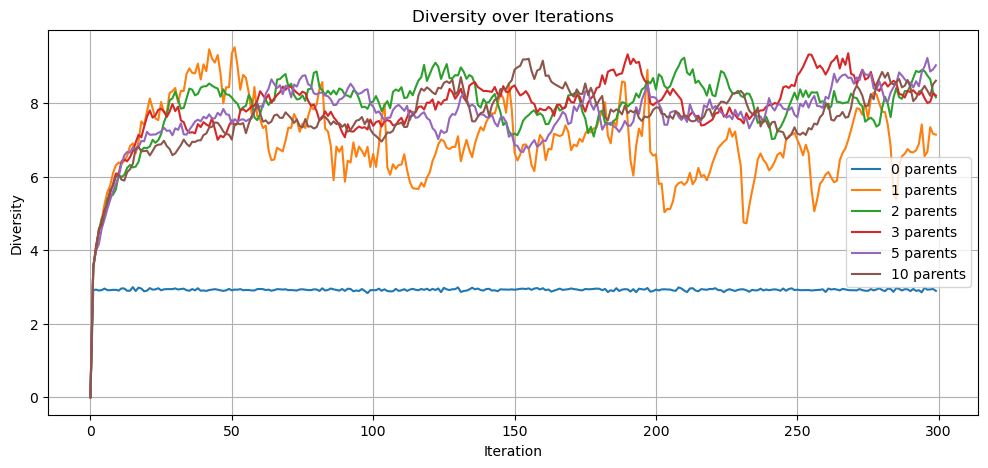

In [ ]:
def plot_diversity(results):
    plt.figure(figsize=(12, 5))
    for num_parents, (_, _, diversities) in results.items():
        plt.plot(diversities, label=f"{num_parents} parents")
    plt.title("Diversity over Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Diversity")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_diversity(results)


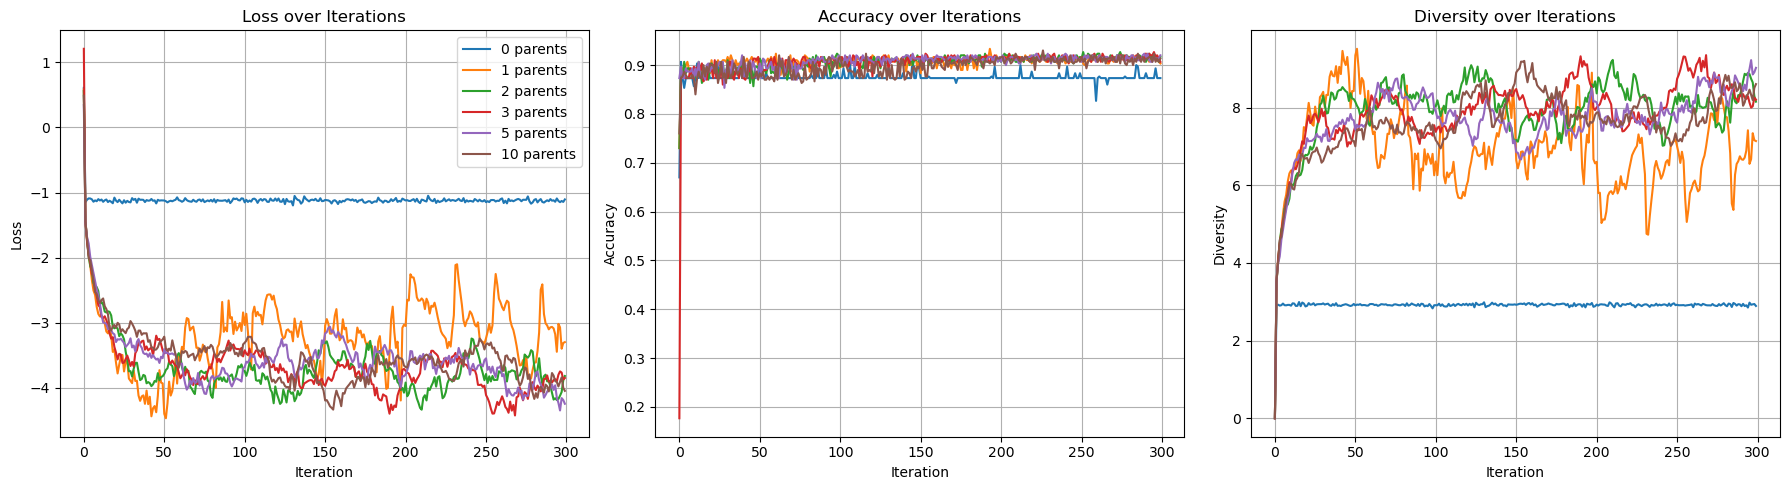

In [49]:
def plot_all_metrics(results):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

    for num_parents, (losses, accs, diversities) in results.items():
        axs[0].plot(losses, label=f"{num_parents} parents")
        axs[1].plot(accs, label=f"{num_parents} parents")
        axs[2].plot(diversities, label=f"{num_parents} parents")

    axs[0].set_title("Loss over Iterations")
    axs[0].set_xlabel("Iteration")
    axs[0].set_ylabel("Loss")
    axs[0].grid(True)

    axs[1].set_title("Accuracy over Iterations")
    axs[1].set_xlabel("Iteration")
    axs[1].set_ylabel("Accuracy")
    axs[1].grid(True)

    axs[2].set_title("Diversity over Iterations")
    axs[2].set_xlabel("Iteration")
    axs[2].set_ylabel("Diversity")
    axs[2].grid(True)

    axs[0].legend()
    plt.tight_layout()
    plt.show()
plot_all_metrics(results)

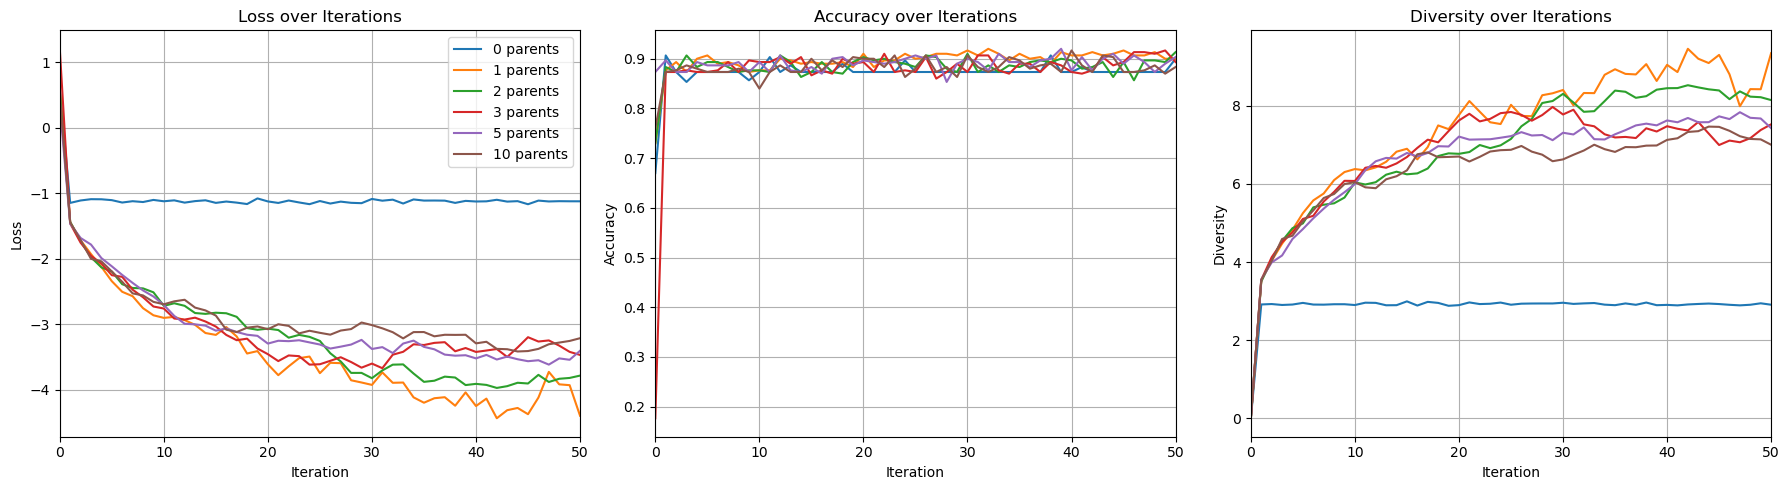

In [ ]:
def plot_all_metrics(results):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

    for num_parents, (losses, accs, diversities) in results.items():
        axs[0].plot(losses[:51], label=f"{num_parents} parents")
        axs[1].plot(accs[:51], label=f"{num_parents} parents")
        axs[2].plot(diversities[:51], label=f"{num_parents} parents")

    axs[0].set_title("Loss over Iterations")
    axs[0].set_xlabel("Iteration")
    axs[0].set_ylabel("Loss")
    axs[0].set_xlim(0, 50)
    axs[0].grid(True)

    axs[1].set_title("Accuracy over Iterations")
    axs[1].set_xlabel("Iteration")
    axs[1].set_ylabel("Accuracy")
    axs[1].set_xlim(0, 50)
    axs[1].grid(True)

    axs[2].set_title("Diversity over Iterations")
    axs[2].set_xlabel("Iteration")
    axs[2].set_ylabel("Diversity")
    axs[2].set_xlim(0, 50)
    axs[2].grid(True)

    axs[0].legend()
    plt.tight_layout()
    plt.show()
plot_all_metrics(results)